# Wojciech Labedz, Urszula Kostuch - projekt 6

### zad za 4 pkt

In [1]:
import glob
import os
import time
import numpy as np

import gymnasium as gym
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

import pettingzoo.utils
from pettingzoo.classic import connect_four_v3

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


class SB3ActionMaskWrapper(pettingzoo.utils.BaseWrapper, gym.Env):
    def reset(self, seed=None, options=None):
        super().reset(seed, options)

        self.observation_space = super().observation_space(self.possible_agents[0])[
            "observation"
        ]
        self.action_space = super().action_space(self.possible_agents[0])

        return self.observe(self.agent_selection), {}

    def step(self, action):
        current_agent = self.agent_selection

        super().step(action)

        next_agent = self.agent_selection
        return (
            self.observe(next_agent),
            self._cumulative_rewards[current_agent],
            self.terminations[current_agent],
            self.truncations[current_agent],
            self.infos[current_agent],
        )

    def observe(self, agent):
        return super().observe(agent)["observation"]

    def action_mask(self):
        return super().observe(self.agent_selection)["action_mask"]


def mask_fn(env):
    return env.action_mask()


class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos")
        if infos is not None:
            for info in infos:
                if info and "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
        return True


def train_action_mask(env_fn, steps=10_000, seed=0, **env_kwargs):
    env = env_fn.env(**env_kwargs)

    print(f"Starting training on {str(env.metadata['name'])}.")

    env = SB3ActionMaskWrapper(env)

    env.reset(seed=seed)
    env = ActionMasker(env, mask_fn)

    model = MaskablePPO(
        MaskableActorCriticPolicy,
        env,
        verbose=1,
        learning_rate=0.00005,
        n_steps=64,
        batch_size=64
    )
    model.set_random_seed(seed)
    reward_logger = RewardLoggingCallback()
    model.learn(total_timesteps=steps, callback=reward_logger)
    model.save(f"{env.unwrapped.metadata.get('name')}")

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.\n")

    env.close()


def eval_action_mask(env_fn, num_games=100, render_mode=None, **env_kwargs):
    env = env_fn.env(render_mode=render_mode, **env_kwargs)

    print(
        f"Starting evaluation vs a random agent. Trained agent will play as {env.possible_agents[1]}."
    )

    try:
        latest_policy = max(
            glob.glob(f"{env.metadata['name']}*.zip"), key=os.path.getctime
        )
    except ValueError:
        print("Policy not found.")
        exit(0)

    model = MaskablePPO.load(latest_policy)

    scores = {agent: 0 for agent in env.possible_agents}
    total_rewards = {agent: 0 for agent in env.possible_agents}
    round_rewards = []
    rewards_per_episode = {agent: [] for agent in env.possible_agents}

    for i in range(num_games):
        env.reset(seed=i)
        env.action_space(env.possible_agents[0]).seed(i)

        episode_rewards = {agent: 0 for agent in env.possible_agents}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            observation, action_mask = obs.values()

            if termination or truncation:
                if (
                    env.rewards[env.possible_agents[0]]
                    != env.rewards[env.possible_agents[1]]
                ):
                    winner = max(env.rewards, key=env.rewards.get)
                    scores[winner] += env.rewards[winner]
                for a in env.possible_agents:
                    total_rewards[a] += env.rewards[a]
                    episode_rewards[a] += env.rewards[a]
                round_rewards.append(env.rewards)
                break
            else:
                if agent == env.possible_agents[0]:
                    act = env.action_space(agent).sample(action_mask)
                else:
                    act = int(
                        model.predict(
                            observation, action_masks=action_mask, deterministic=True
                        )[0]
                    )
            env.step(act)
            for a in env.possible_agents:
                episode_rewards[a] += env.rewards[a]

        for a in env.possible_agents:
            rewards_per_episode[a].append(episode_rewards[a])

    env.close()

    # Wykres reward per episode
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_per_episode[env.possible_agents[1]], label="Trained agent (PPO)")
    plt.plot(rewards_per_episode[env.possible_agents[0]], label="Random agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward per episode")
    plt.title("Reward per episode: PPO vs Random agent")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wykres total rewards
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(rewards_per_episode[env.possible_agents[1]]), label="Trained agent (PPO) - Total reward")
    plt.plot(np.cumsum(rewards_per_episode[env.possible_agents[0]]), label="Random agent - Total reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per agent")
    plt.legend()
    plt.grid(True)
    plt.show()

    if sum(scores.values()) == 0:
        winrate = 0
    else:
        winrate = scores[env.possible_agents[1]] / sum(scores.values())
    print("Rewards by round: ", round_rewards)
    print("Total rewards: ", total_rewards)
    print("Winrate: ", winrate)
    print("Final scores: ", scores)
    return round_rewards, total_rewards, winrate, scores

/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB6/my-env/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Starting training on connect_four_v3.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 3203     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 64       |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 21            |
|    ep_rew_mean          | 1             |
| time/                   |               |
|    fps                  | 1484          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 1.8072315e-05 |
|    clip_fraction        | 0             |


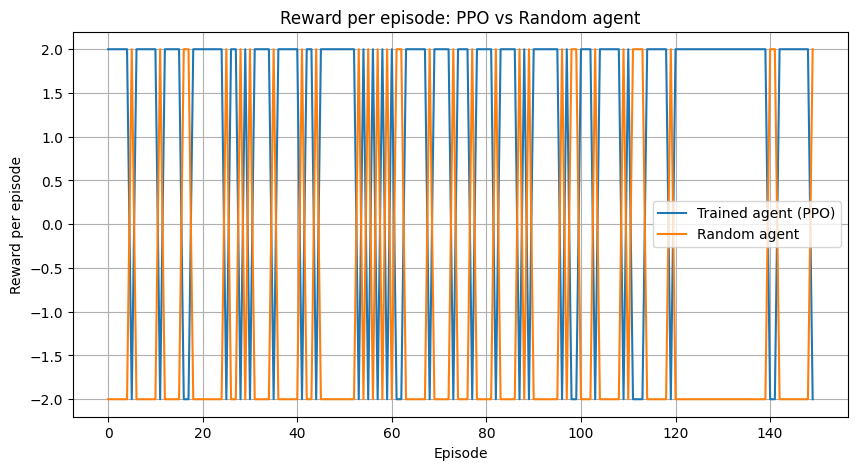

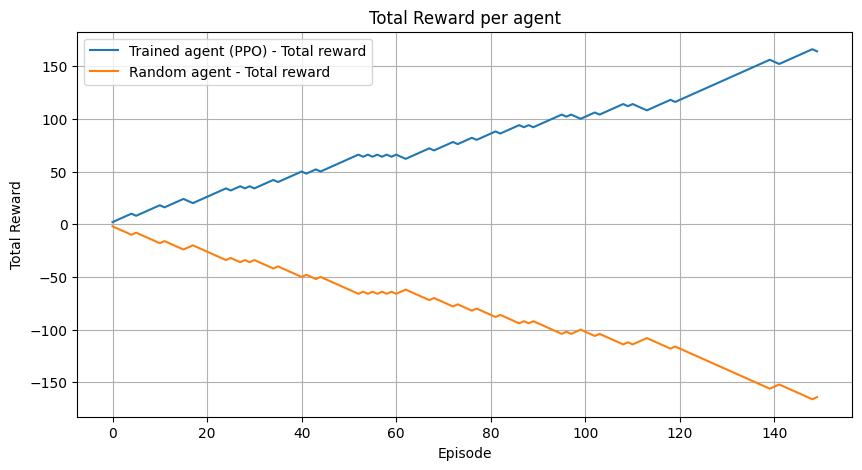

Rewards by round:  [{'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'playe

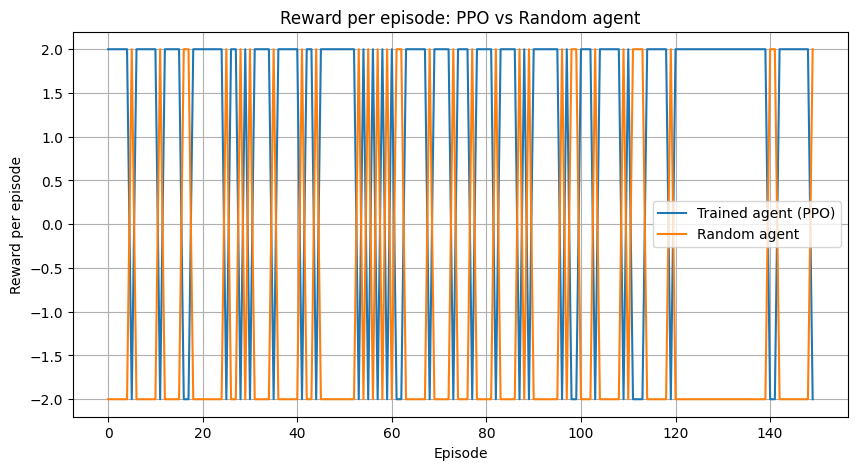

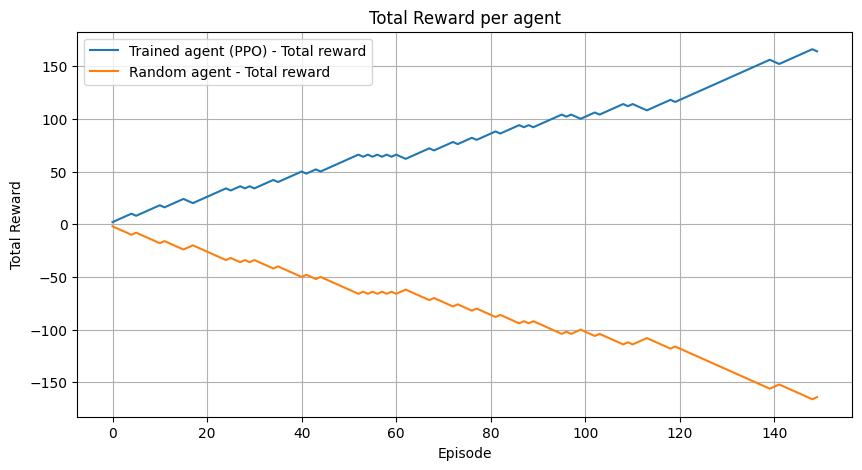

Rewards by round:  [{'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'playe

([{'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'p

In [2]:
env_fn = connect_four_v3

env_kwargs = {}

# Train a model against itself
train_action_mask(env_fn, steps=20_000, seed=0, **env_kwargs)

# Evaluate 100 games against a random agent 
eval_action_mask(env_fn, num_games=150, render_mode=None, **env_kwargs)

# Watch two games vs a random agent
eval_action_mask(env_fn, num_games=150, render_mode="human", **env_kwargs)

### zad za 8 pkt

In [3]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C

class CardGameEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(13)
        self.action_space = spaces.Discrete(13)
        self.deck = list(range(13))
        self.reset()

    def reset(self):
        self.agent1_card = np.random.choice(self.deck)
        self.agent2_card = np.random.choice(self.deck)
        return self.agent1_card

    def step(self, action1):
        action2 = np.random.choice(self.deck)  # przeciwnik losowy
        reward1 = 1 if action1 > action2 else -1 if action1 < action2 else 0
        next_obs = np.random.choice(self.deck)
        done = True
        return next_obs, reward1, done, {"agent2_card": action2}

In [4]:
class Agent2Env(gym.Env):
    def __init__(self):
        super().__init__()
        self.deck = list(range(13))
        self.observation_space = spaces.Discrete(13)
        self.action_space = spaces.Discrete(13)

    def reset(self):
        self.agent2_card = np.random.choice(self.deck)
        return self.agent2_card

    def step(self, action2):
        action1 = np.random.choice(self.deck)  # przeciwnik losowy
        reward2 = 1 if action2 > action1 else -1 if action2 < action1 else 0
        next_obs = np.random.choice(self.deck)
        done = True
        return next_obs, reward2, done, {"agent1_card": action1}

In [5]:
def evaluate_model(model, env, episodes=100):
    rewards = []
    for _ in range(episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return rewards

In [6]:
# zestawy hiperparametrów
ppo_param_sets = [
    {"learning_rate": 0.03, "n_steps": 256, "batch_size": 64},
    {"learning_rate": 0.001,  "n_steps": 1024, "batch_size": 32},
    {"learning_rate": 0.0001, "n_steps": 512,  "batch_size": 16},
]

a2c_param_sets = [
    {"learning_rate": 0.0007, "n_steps": 5},
    {"learning_rate": 0.001,  "n_steps": 10},
    {"learning_rate": 0.0002, "n_steps": 20},
]

ppo_results = []
a2c_results = []

#PPO
for i, params in enumerate(ppo_param_sets):
    env1 = CardGameEnv()
    model1 = PPO("MlpPolicy", env1, verbose=0, **params)
    for _ in range(50):
        model1.learn(total_timesteps=1000, reset_num_timesteps=False)
    rewards = evaluate_model(model1, env1, episodes=100)
    ppo_results.append(rewards)
    print(f"PPO set {i+1} mean reward: {np.mean(rewards):.2f}")

#A2C
for i, params in enumerate(a2c_param_sets):
    env2 = Agent2Env()
    model2 = A2C("MlpPolicy", env2, verbose=0, **params)
    for _ in range(50):
        model2.learn(total_timesteps=1000, reset_num_timesteps=False)
    rewards = evaluate_model(model2, env2, episodes=100)
    a2c_results.append(rewards)
    print(f"A2C set {i+1} mean reward: {np.mean(rewards):.2f}")

/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB6/my-env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


PPO set 1 mean reward: 0.95
PPO set 2 mean reward: 0.94
PPO set 3 mean reward: 0.95
A2C set 1 mean reward: 0.90
A2C set 2 mean reward: 0.90
A2C set 3 mean reward: 0.88


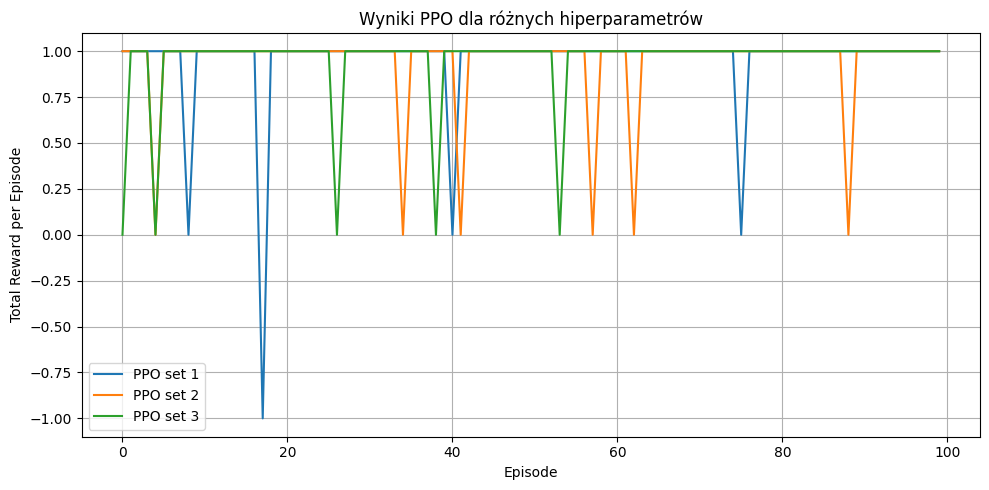

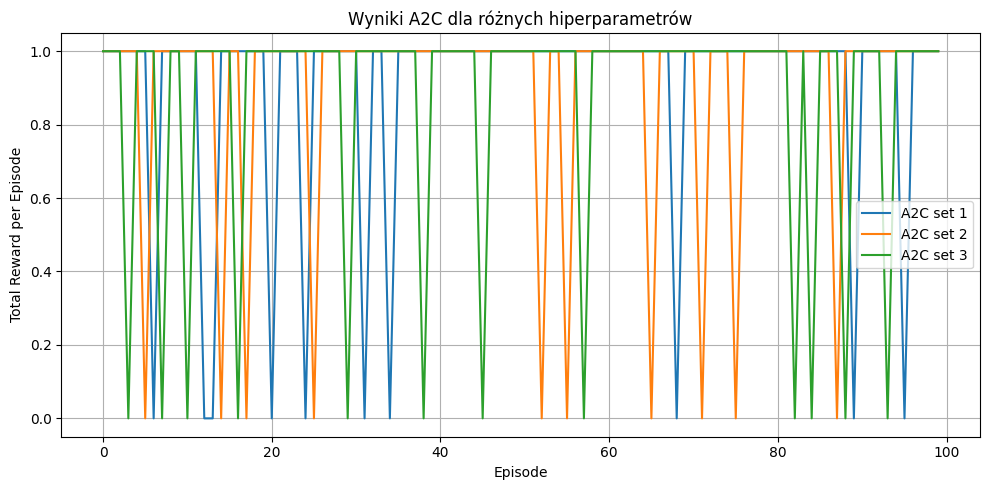

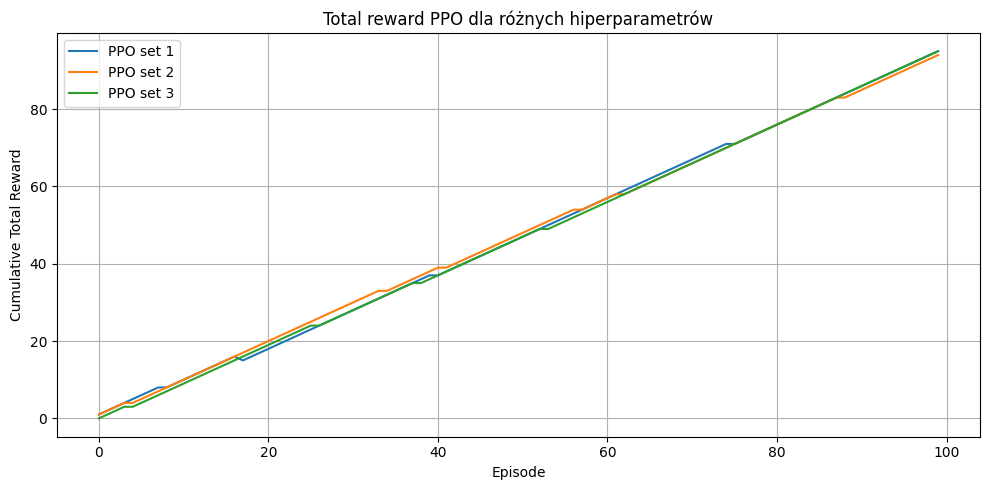

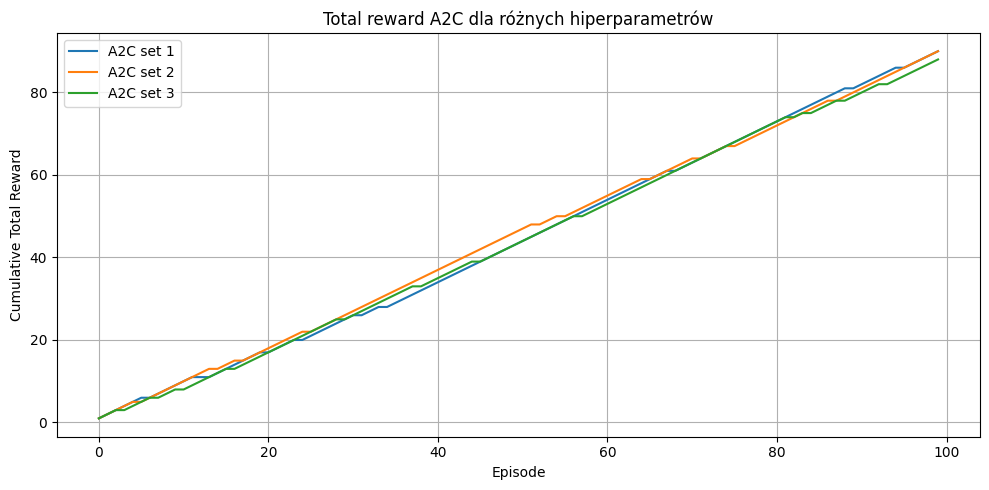

In [7]:
# wykresy
plt.figure(figsize=(10, 5))
for i, rewards in enumerate(ppo_results):
    plt.plot(rewards, label=f"PPO set {i+1}")
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Wyniki PPO dla różnych hiperparametrów")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, rewards in enumerate(a2c_results):
    plt.plot(rewards, label=f"A2C set {i+1}")
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Wyniki A2C dla różnych hiperparametrów")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, rewards in enumerate(ppo_results):
    plt.plot(np.cumsum(rewards), label=f"PPO set {i+1}")
plt.xlabel("Episode")
plt.ylabel("Cumulative Total Reward")
plt.title("Total reward PPO dla różnych hiperparametrów")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, rewards in enumerate(a2c_results):
    plt.plot(np.cumsum(rewards), label=f"A2C set {i+1}")
plt.xlabel("Episode")
plt.ylabel("Cumulative Total Reward")
plt.title("Total reward A2C dla różnych hiperparametrów")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#najlepsze modele
best_ppo_idx = int(np.argmax([np.mean(r) for r in ppo_results]))
best_a2c_idx = int(np.argmax([np.mean(r) for r in a2c_results]))

ppo_best = PPO("MlpPolicy", CardGameEnv(), verbose=0, **ppo_param_sets[best_ppo_idx])
ppo_best.learn(total_timesteps=50000)

a2c_best = A2C("MlpPolicy", Agent2Env(), verbose=0, **a2c_param_sets[best_a2c_idx])
a2c_best.learn(total_timesteps=50000)

In [9]:
# rozgrywki miedzy wytrenownymi modelami
def duel(model1, model2, env_class, games=100):
    wins1, wins2, draws = 0, 0, 0
    for _ in range(games):
        env = env_class()
        obs1 = env.reset()
        obs2 = obs1 if hasattr(env, 'agent2_card') else None
        action1, _ = model1.predict(obs1, deterministic=True)
        if isinstance(env, CardGameEnv):
            action2, _ = model2.predict(env.agent2_card, deterministic=True)
            if action1 > action2:
                wins1 += 1
            elif action1 < action2:
                wins2 += 1
            else:
                draws += 1
        else:
            action2, _ = model2.predict(obs2, deterministic=True)
            action1 = np.random.choice(env.deck)
            if action2 > action1:
                wins2 += 1
            elif action2 < action1:
                wins1 += 1
            else:
                draws += 1
    return wins1, wins2, draws

def duel_ppo_vs_a2c(model_ppo, model_a2c, games=100):
    wins_ppo, wins_a2c, draws = 0, 0, 0
    for _ in range(games):
        env = CardGameEnv()
        obs = env.reset()
        action_ppo, _ = model_ppo.predict(obs, deterministic=True)
        action_a2c, _ = model_a2c.predict(env.agent2_card, deterministic=True)
        if action_ppo > action_a2c:
            wins_ppo += 1
        elif action_ppo < action_a2c:
            wins_a2c += 1
        else:
            draws += 1
    return wins_ppo, wins_a2c, draws


In [10]:
# PPO vs PPO
w1, w2, d = duel(ppo_best, ppo_best, CardGameEnv, games=100)
print(f"PPO vs PPO: Agent1 wins: {w1}, Agent2 wins: {w2}, Draws: {d}")

# A2C vs A2C
w1, w2, d = duel(a2c_best, a2c_best, Agent2Env, games=100)
print(f"A2C vs A2C: Agent1 wins: {w1}, Agent2 wins: {w2}, Draws: {d}")

# PPO vs A2C
w_ppo, w_a2c, d = duel_ppo_vs_a2c(ppo_best, a2c_best, games=100)
print(f"PPO vs A2C: PPO wins: {w_ppo}, A2C wins: {w_a2c}, Draws: {d}")

PPO vs PPO: Agent1 wins: 17, Agent2 wins: 23, Draws: 60
A2C vs A2C: Agent1 wins: 0, Agent2 wins: 92, Draws: 8
PPO vs A2C: PPO wins: 0, A2C wins: 90, Draws: 10


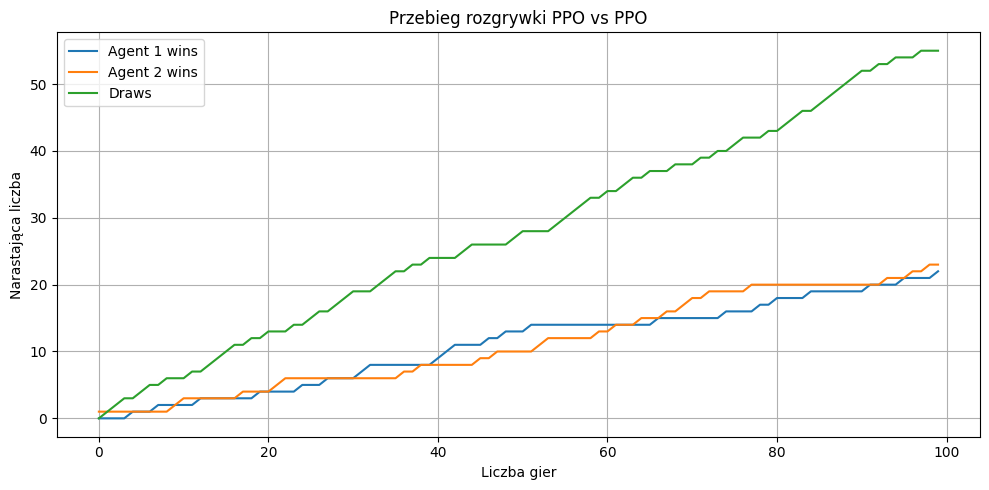

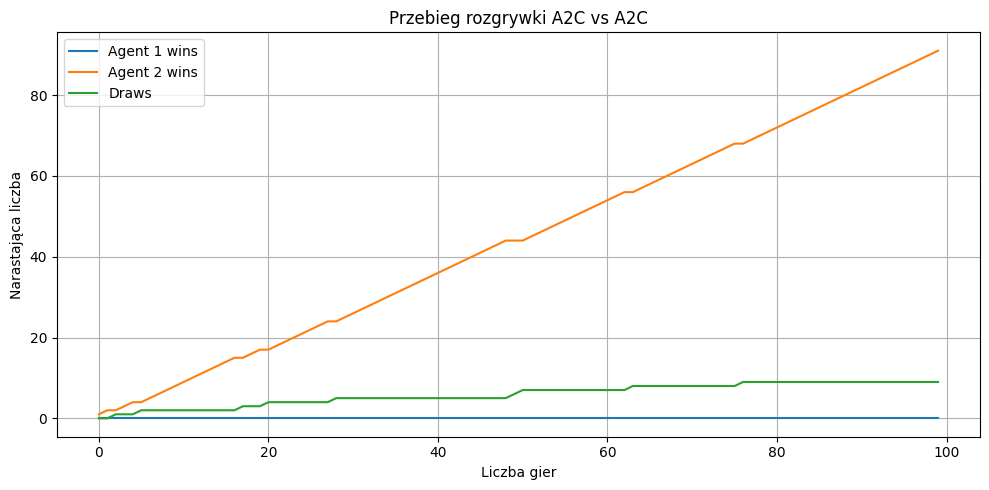

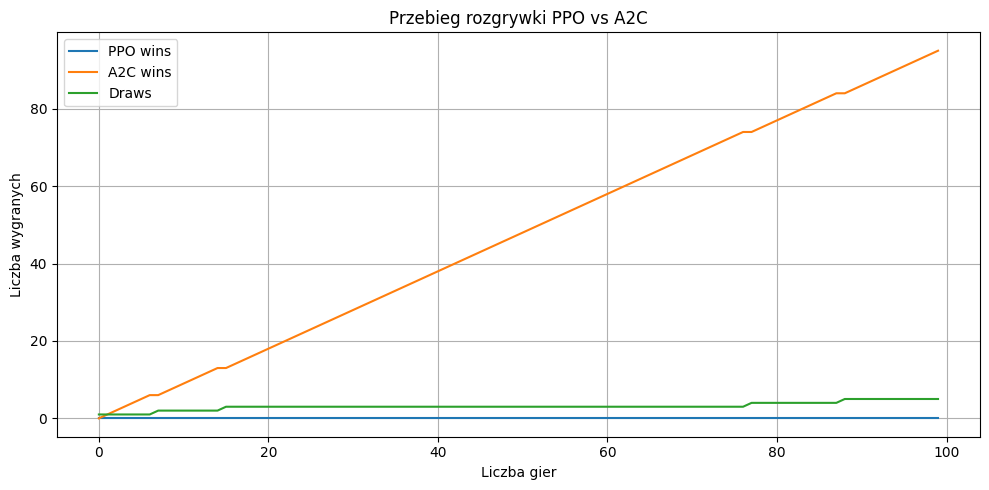

In [11]:
def plot_duel_progress(model1, model2, env_class, games=100, title="Przebieg rozgrywki"):
    wins1, wins2, draws = [], [], []
    c1 = c2 = cd = 0
    for _ in range(games):
        env = env_class()
        obs1 = env.reset()
        action1, _ = model1.predict(obs1, deterministic=True)
        if isinstance(env, CardGameEnv):
            action2, _ = model2.predict(env.agent2_card, deterministic=True)
            if action1 > action2:
                c1 += 1
            elif action1 < action2:
                c2 += 1
            else:
                cd += 1
        else:
            obs2 = obs1 if hasattr(env, 'agent2_card') else None
            action2, _ = model2.predict(obs2, deterministic=True)
            action1 = np.random.choice(env.deck)
            if action2 > action1:
                c2 += 1
            elif action2 < action1:
                c1 += 1
            else:
                cd += 1
        wins1.append(c1)
        wins2.append(c2)
        draws.append(cd)
    plt.figure(figsize=(10,5))
    plt.plot(wins1, label="Agent 1 wins")
    plt.plot(wins2, label="Agent 2 wins")
    plt.plot(draws, label="Draws")
    plt.xlabel("Liczba gier")
    plt.ylabel("Narastająca liczba")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_duel_progress(ppo_best, ppo_best, CardGameEnv, games=100, title="Przebieg rozgrywki PPO vs PPO")
plot_duel_progress(a2c_best, a2c_best, Agent2Env, games=100, title="Przebieg rozgrywki A2C vs A2C")

def plot_duel_progress_ppo_vs_a2c(model_ppo, model_a2c, games=100, title="Przebieg rozgrywki PPO vs A2C"):
    wins_ppo, wins_a2c, draws = [], [], []
    c1 = c2 = cd = 0
    for _ in range(games):
        env = CardGameEnv()
        obs = env.reset()
        action_ppo, _ = model_ppo.predict(obs, deterministic=True)
        action_a2c, _ = model_a2c.predict(env.agent2_card, deterministic=True)
        if action_ppo > action_a2c:
            c1 += 1
        elif action_ppo < action_a2c:
            c2 += 1
        else:
            cd += 1
        wins_ppo.append(c1)
        wins_a2c.append(c2)
        draws.append(cd)
    plt.figure(figsize=(10,5))
    plt.plot(wins_ppo, label="PPO wins")
    plt.plot(wins_a2c, label="A2C wins")
    plt.plot(draws, label="Draws")
    plt.xlabel("Liczba gier")
    plt.ylabel("Liczba wygranych")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_duel_progress_ppo_vs_a2c(ppo_best, a2c_best, games=100, title="Przebieg rozgrywki PPO vs A2C")